## Analysis for generating traces with preset ROI having a certain amplitude AP

This file runs optimizeKaDensity. It finds the KaDensity that brings the AP amplitude in the target ROI to a requested amplitude. 
It does this for the intact cell and then uses the same parameters for the cut cell.

In this run, we're saving KaDensity, ApAmp, CaAmp, InputResistance (computed with a -10pA injection into the site), and EPSP size in dendrite and soma (using an alpha synapse with properties TBD). 

In [1]:
%load_ext autoreload
%autoreload

import numpy as np
from neuron import h, gui

from collection_uncageMapping import L23
import morphologyFunctions as mfx
import neuronFunctions as nfx

from matplotlib import pyplot as plt
from matplotlib import cm

from scipy.io import savemat, loadmat

import pickle
import time

from scipy.optimize import minimize

In [2]:
import sys
print("Python version")
print (sys.version)
print("Version info.")
print (sys.version_info)

Python version
3.8.3 (default, Jul  2 2020, 11:26:31) 
[Clang 10.0.0 ]
Version info.
sys.version_info(major=3, minor=8, micro=3, releaselevel='final', serial=0)


In [3]:
from contextlib import contextmanager
import sys, os

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

In [4]:
def determineKaDensity(kaDensity, targetAmplitude, cellID, cutExperiment, naDensity, idxROI):
    # Create cell
    for sec in h.allsec(): h.delete_section(sec=sec)
    with suppress_stdout():
        cell1 = L23(cellID=cellID,cutExperiment=cutExperiment,dendNa=[naDensity,None,None,False],dendK=[kaDensity,np.inf,True,False],dxSeg=1,fixDiam=None);

    # Record response of AP at all desired sites
    stim1 = nfx.attachCC(cell1.soma, delay=1, dur=1, amp=3.5, loc=0.5) # set stim up for somatic injection
    
    tv = h.Vector() # Time stamp vector
    tv.record(h._ref_t)
    
    vsec = h.Vector()
    vsec.record(getattr(cell1.sectionList[idxROI](cell1.segmentList[idxROI]),'_ref_v'))
    
    # Simulate Data
    nfx.simulate(tstop=15,v_init=-75,celsius=35)

    # Analyze Data
    vData = np.array(vsec)
    apAmp = np.amax(vData)

    # Reset stim program
    stim1 = None
    
    return np.abs(apAmp - targetAmplitude)

def saveKaResults(fname, kaDensity, apAmp, caAmp, vTraces, cTraces, tv, cellID, idxROI, silentID, ires, cutExperiment, epspAmpDend, epspAmpSoma, epspDendTraces,epspSomaTraces,tvEpsp):
    saveList = [kaDensity, apAmp, caAmp, vTraces, cTraces, tv, cellID, idxROI, silentID, ires, cutExperiment, epspAmpDend, epspAmpSoma, epspDendTraces,epspSomaTraces,tvEpsp]
    fid = open(fname,'wb')
    pickle.dump(saveList, fid)
    fid.close()
    return None

def loadKaResults(fname):
    fid = open(fname,'rb')
    loadedData = pickle.load(fid)
    fid.close()
    kaDensity=loadedData[0]
    apAmp=loadedData[1]
    caAmp=loadedData[2]
    vTraces=loadedData[3]
    cTraces=loadedData[4]
    tv=loadedData[5]
    cellID=loadedData[6]
    idxROI=loadedData[7]
    silentID=loadedData[8]
    ires=loadedData[9]
    cutExperiment=loadedData[10]
    epspAmpDend=loadedData[11]
    epspAmpSoma=loadedData[12]
    epspDendTraces=loadedData[13]
    epspSomaTraces=loadedData[14]
    tvEpsp=loadedData[15]
    return kaDensity,apAmp,caAmp,vTraces,cTraces,tv,cellID,idxROI,silentID,ires,cutExperiment,epspAmpDend,epspAmpSoma,epspDendTraces,epspSomaTraces,tvEpsp

In [4]:
numCells = 8
naDensity = 5
initKaDensity = 0.01
kaBounds = (0,None)
roiType = False # True means silent, False means active (will get all from each category)
targetAmplitude = -10

cellID = []
cutExperiment = []
idxROI = []
silentID = []
tv = []
vTraces = []
cTraces = []

kaDensity = []
apAmp = []
caAmp = []

ires = []

epspAmpDend = []
epspAmpSoma = []
epspDendTraces = []
epspSomaTraces = []
tvEpsp = []

for n in range(numCells):
    # Create cell just to get silent IDs
    for sec in h.allsec(): h.delete_section(sec=sec)
    cell1 = L23(cellID=n,cutExperiment=0,dendNa=[naDensity,None,None,False],dendK=[initKaDensity,np.inf,True,False],dxSeg=1,fixDiam=None);
    cSilentID = cell1.silentID
    
    # Trade out these two lines to use all or just active/silent type of interest
    listTarget = [n for n in range(len(cSilentID))]
    #listTarget = [n for n in range(len(cSilentID)) if cSilentID[n]==roiType]
    
    for r in listTarget:
        print(f'Working on cell {n+1}/{numCells}, ROI {r}')
        
        # -- do it for the normal cell -- 
        
        # Optimize kaDensity for this cell
        results = minimize(determineKaDensity, initKaDensity, args=(targetAmplitude,n,0,naDensity,r),method='Nelder-Mead',bounds=kaBounds)
        kaDensity.append(results.x) # Store optimal kaDensity

        # Run cell with optimal kaDensity and record voltage/calcium traces for all ROIs in the cell
        for sec in h.allsec(): h.delete_section(sec=sec)
        cell1 = L23(cellID=n,cutExperiment=0,dendNa=[naDensity,None,None,False],dendK=[results.x,np.inf,True,False],dxSeg=1,fixDiam=None);
        
        # Record response of AP at all desired sites
        stim1 = nfx.attachCC(cell1.soma, delay=1, dur=1, amp=3.5, loc=0.5) # set stim up for somatic injection
        
        # Record peak of AP in all the sites
        vsec,ctv = mfx.recordSites(cell1.sectionList,cell1.segmentList)

        # Record ica in all sites + soma
        csec = mfx.recordSites(cell1.sectionList,cell1.segmentList,recordVariable='_ref_ica')[0]

        # Simulate Data
        nfx.simulate(tstop=15,v_init=-75,celsius=35)

        # Convert calcium current to conductance
        gca_sec = []
        for ica,v in zip(csec,vsec):
            gca_sec.append(nfx.conductanceFromCurrent(ica,v,cell1.Eca))
        
        # Store Data
        cellID.append(n)
        cutExperiment.append(0)
        idxROI.append(r)
        silentID.append(cSilentID[r])
        vData = np.array(vsec)
        gcaData = np.array(gca_sec)
        apAmp.append(np.amax(vData,axis=1))
        caAmp.append(np.amax(gcaData,axis=1))
        vTraces.append(vData)
        cTraces.append(gcaData)
        tv.append(np.array(ctv))
        
        # --------- And also measure input resistance for sites!! ---------
        stim = None
        amplitude=-0.01
        vsection,ctv,stim = mfx.injectSites(cell1.sectionList,cell1.segmentList,stim=stim,amplitude=amplitude)

        # Reset stim program
        stim = None

        # Delay is 50ms, duration is 50ms
        dvm = (np.array(vsection)[:,np.where(np.array(ctv)<=100)[0][-1]] - np.array(vsection)[:,np.where(np.array(ctv)<=50)[0][-1]])
        ires.append(dvm/amplitude)        
        
        # --------- And also measure EPSP size and transfer function for sites! ---------
        syn = None
        stim = None
        onset=50
        tau=1
        gmax=0.0005
        tstop = 80
        epspDendrite,epspSoma,epspTV,syn = mfx.injectAlphaSites(cell1.sectionList,cell1.segmentList,syn=syn,onset=onset,tau=tau,gmax=gmax,tstop=tstop)
        vEpspDend = np.array(epspDendrite)
        vEpspSoma = np.array(epspSoma)
        cTvEpsp = np.array(epspTV)
        cEpspAmpDend = np.amax(vEpspDend,axis=1) - vEpspDend[:,np.where(cTvEpsp>=onset-1)[0][0]]
        cEpspAmpSoma = np.amax(vEpspSoma,axis=1) - vEpspSoma[:,np.where(cTvEpsp>=onset-1)[0][0]]
        epspAmpDend.append(cEpspAmpDend)
        epspAmpSoma.append(cEpspAmpSoma)
        epspDendTraces.append(vEpspDend)
        epspSomaTraces.append(vEpspSoma)
        tvEpsp.append(cTvEpsp)
        
        print(f'Finished. AP Amps: {apAmp[-1]}, CaAmps: {caAmp[-1]}, Ires: {ires[-1]}, EpspDend: {epspAmpDend[-1]}, EpspSoma: {epspAmpSoma[-1]}')

        # Reset stim programs
        syn = None
        stim = None
        
        
        # -- now measure it again for the cut experiment -- (using the same fit parameters)
        kaDensity.append(results.x) # Store optimal kaDensity

        # Run cell with optimal kaDensity and record voltage/calcium traces for all ROIs in the cell
        for sec in h.allsec(): h.delete_section(sec=sec)
        cell1 = L23(cellID=n,cutExperiment=2,dendNa=[naDensity,None,None,False],dendK=[results.x,np.inf,True,False],dxSeg=1,fixDiam=None);
        
        # Record response of AP at all desired sites
        stim1 = nfx.attachCC(cell1.soma, delay=1, dur=1, amp=3.5, loc=0.5) # set stim up for somatic injection
        
        # Record peak of AP in all the sites
        vsec,ctv = mfx.recordSites(cell1.sectionList,cell1.segmentList)

        # Record ica in all sites + soma
        csec = mfx.recordSites(cell1.sectionList,cell1.segmentList,recordVariable='_ref_ica')[0]

        # Simulate Data
        nfx.simulate(tstop=15,v_init=-75,celsius=35)

        # Convert calcium current to conductance
        gca_sec = []
        for ica,v in zip(csec,vsec):
            gca_sec.append(nfx.conductanceFromCurrent(ica,v,cell1.Eca))
        
        # Store Data
        cellID.append(n)
        cutExperiment.append(1)
        idxROI.append(r)
        silentID.append(cSilentID[r])
        vData = np.array(vsec)
        gcaData = np.array(gca_sec)
        apAmp.append(np.amax(vData,axis=1))
        caAmp.append(np.amax(gcaData,axis=1))
        vTraces.append(vData)
        cTraces.append(gcaData)
        tv.append(np.array(ctv))
        
        # And also measure input resistance for sites!!
        stim = None
        amplitude=-0.01
        vsection,ctv,stim = mfx.injectSites(cell1.sectionList,cell1.segmentList,stim=stim,amplitude=amplitude)

        # Delay is 50ms, duration is 50ms
        dvm = (np.array(vsection)[:,np.where(np.array(ctv)<=100)[0][-1]] - np.array(vsection)[:,np.where(np.array(ctv)<=50)[0][-1]])
        ires.append(dvm/amplitude)        
        
        # --------- And also measure EPSP size and transfer function for sites! ---------
        syn = None
        stim = None
        onset=50
        tau=1
        gmax=0.0005
        tstop = 80
        epspDendrite,epspSoma,epspTV,syn = mfx.injectAlphaSites(cell1.sectionList,cell1.segmentList,syn=syn,onset=onset,tau=tau,gmax=gmax,tstop=tstop)
        vEpspDend = np.array(epspDendrite)
        vEpspSoma = np.array(epspSoma)
        cTvEpsp = np.array(epspTV)
        cEpspAmpDend = np.amax(vEpspDend,axis=1) - vEpspDend[:,np.where(cTvEpsp>=onset-1)[0][0]]
        cEpspAmpSoma = np.amax(vEpspSoma,axis=1) - vEpspSoma[:,np.where(cTvEpsp>=onset-1)[0][0]]
        epspAmpDend.append(cEpspAmpDend)
        epspAmpSoma.append(cEpspAmpSoma)
        epspDendTraces.append(vEpspDend)
        epspSomaTraces.append(vEpspSoma)
        tvEpsp.append(cTvEpsp)
        
        print(f'Finished. AP Amps: {apAmp[-1]}, CaAmps: {caAmp[-1]}, Ires: {ires[-1]}, EpspDend: {epspAmpDend[-1]}, EpspSoma: {epspAmpSoma[-1]}')

        # Reset stim programs
        syn = None
        stim = None

	1 
Working on cell 1/8, ROI 0


/Users/landauland/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)


	1 
Finished. AP Amps: [-10.00358794  20.27465247  25.56092725], CaAmps: [0.81316706 0.82157671 0.82321652], Ires: [173.44511708 217.64758335 231.6342793 ], EpspDend: [ 34.94748895  95.66144076 100.9685486 ], EpspSoma: [131.10942751 131.10942751 131.10942751]
	1 
Finished. AP Amps: [34.75796886 20.18378546 25.46382164], CaAmps: [0.8245904  0.82099055 0.82273432], Ires: [272.00062466 235.14469097 248.2293201 ], EpspDend: [110.15504599  95.57894869 100.87945937], EpspSoma: [131.13077219 131.13077219 131.13077219]
Working on cell 1/8, ROI 1
	1 
Finished. AP Amps: [-57.77896986  -9.99952549  -3.42569343], CaAmps: [0.0047663  0.60698104 0.74083222], Ires: [170.48564315 214.37690715 228.20678035], EpspDend: [16.5303956  27.13959734 24.37369643], EpspSoma: [130.2486427 130.2486427 130.2486427]
	1 
Finished. AP Amps: [28.14738442 12.01116266 17.72438175], CaAmps: [0.80895914 0.80402002 0.80600431], Ires: [267.66870775 230.73290449 243.67003799], EpspDend: [103.74066145  87.73170298  93.4764383

In [5]:
timeStamp = time.strftime("optKaDensity_%Y%b%d_%H%M%S_sameFits")
fname = './'+timeStamp+'.pkl'
saveKaResults(fname, kaDensity, apAmp, caAmp, vTraces, cTraces, tv, cellID, idxROI, silentID, ires, cutExperiment, epspAmpDend, epspAmpSoma, epspDendTraces, epspSomaTraces, tvEpsp)

# Stack saved results in format matlab will like
numFits = len(kaDensity)
maxROI = 4
NT = tv[0].shape[0]
matVoltage = np.empty((NT,numFits,maxROI))
matVoltage[:] = np.NAN
matCalcium = np.empty_like(matVoltage)
matCalcium[:] = np.NAN
matTv = tv[0]
matApAmp = np.empty((numFits,maxROI))
matApAmp[:] = np.NAN
matCaAmp = np.empty_like(matApAmp)
matCaAmp[:] = np.NAN
matIres = np.empty_like(matApAmp)
matIres[:] = np.NAN
matKaDensity = np.empty_like(matApAmp)
matCellID = np.empty(numFits)
matIdxROI = np.empty(numFits)
matCutExp = np.empty(numFits)
matEpspDend = np.empty_like(matApAmp)
matEpspSoma = np.empty_like(matApAmp)
matEpspDend[:] = np.NAN
matEpspSoma[:] = np.NAN
NT = tvEpsp[0].shape[0]
matEpspDendTraces = np.empty((NT,numFits,maxROI))
matEpspSomaTraces = np.empty((NT,numFits,maxROI))
matEpspDendTraces[:] = np.NAN
matEpspSomaTraces[:] = np.NAN
for n in range(numFits):
    cNumROI = vTraces[n].shape[0]
    matVoltage[:,n,:cNumROI] = vTraces[n].T
    matCalcium[:,n,:cNumROI] = cTraces[n].T
    matApAmp[n,:cNumROI] = apAmp[n]
    matCaAmp[n,:cNumROI] = caAmp[n]
    matIres[n,:cNumROI] = ires[n]
    matEpspDend[n,:cNumROI] = epspAmpDend[n]
    matEpspSoma[n,:cNumROI] = epspAmpSoma[n]
    matKaDensity[n] = kaDensity[n]
    matCellID[n] = cellID[n]
    matIdxROI[n] = idxROI[n]
    matCutExp[n] = cutExperiment[n]
    matEpspDendTraces[:,n,:cNumROI] = epspDendTraces[n].T
    matEpspSomaTraces[:,n,:cNumROI] = epspSomaTraces[n].T

matname = './'+timeStamp+'.mat'
matdict = {"matVoltage":matVoltage, "matCalcium":matCalcium, "matApAmp":matApAmp,"matCaAmp":matCaAmp,"matIres":matIres,"matKaDensity":matKaDensity,"matCellID":matCellID,"matIdxROI":matIdxROI,\
           "matTV":matTv,"matCutExp":matCutExp,"silentID":np.array(silentID),"epspAmpDend":matEpspDend,"epspAmpSoma":matEpspSoma,"epspDendTraces":matEpspDendTraces,"epspSomaTraces":matEpspSomaTraces,"tvEpsp":tvEpsp}
savemat(matname,matdict)

In [7]:
fname = './optKaDensity_2021Aug31_152955_sameFits.pkl'
kaDensity,apAmp,caAmp,vTraces,cTraces,tv,cellID,idxROI,silentID,ires,cutExperiment,epspAmpDend,epspAmpSoma,epspDendTraces,epspSomaTraces,tvEpsp = loadKaResults(fname)

## Everything below this is just for playing with the data

In [9]:
silentID

[True,
 True,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 True,
 True,
 False,
 False,
 True,
 True,
 False,
 False,
 True,
 True,
 False,
 False,
 True,
 True,
 False,
 False]

TypeError: 'bool' object is not subscriptable

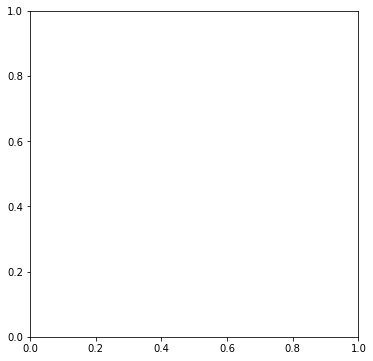

In [8]:
# Plot Somatic AP
fig = plt.figure(figsize=(20,6))

cmap = cm.get_cmap('jet')

numFits = len(kaDensity)

plt.subplot(1,3,1)
for n in range(numFits):
    numROI = vTraces[n].shape[0]
    for r in range(numROI):
        if silentID[n][r]==False and idxROI[n]!=r: continue
        ccol = 'b'
        if silentID[n][r]==False: ccol = 'k'
        plt.plot(np.array(tv[n]),vTraces[n][r].T,c=ccol)

plt.subplot(1,3,2)
for n in range(numFits):
    numROI = cTraces[n].shape[0]
    for r in range(numROI):
        if silentID[n][r]==False and idxROI[n]!=r: continue
        ccol = 'b'
        if silentID[n][r]==False: ccol = 'k'
        plt.plot(np.array(tv[n]),cTraces[n][r].T,c=ccol)

plt.subplot(1,3,3)
for n in range(numFits):
    numROI = cTraces[n].shape[0]
    for r in range(numROI):
        if silentID[n][r]==False and idxROI[n]!=r: continue
        ccol = 'b'
        if silentID[n][r]==False: ccol = 'k'
        plt.scatter(apAmp[n][r],caAmp[n][r],c=ccol,s=80)
    plt.plot([apAmp[n][0],apAmp[n][idxROI[n]]],[caAmp[n][0],caAmp[n][idxROI[n]]],c='k',linewidth=0.2,linestyle='dashed')

In [ ]:
cellID = 0
cutExperiment = 0
idxROI = 0

naDensity = 6
targetAmplitude = -20
initKaDensity = 0.01

results = minimize(determineKaDensity, initKaDensity, args=(targetAmplitude, cellID, cutExperiment, naDensity, idxROI),method='Nelder-Mead',bounds=(0,None))


In [10]:
# In this cell, I'll go through the cells and vary the potassium channel density until the requested ROI has an AP amplitude of a set voltage. 

numCells = 8 # number of cells to run through
naDensity = 6 # Na channel density (in channels / um2)
initKaDensity = 0.01 # K channel density (in units of S/cm2)
kaMinimum = 0 # minimum k channel density 
kaMaximum = 0.2 # maximum k channel density
stepSize = 0.00001 # ka S/cm2 per mV
tolerance = 0.05 # tolerance in mV for AP

# Index of ROI to set AP amplitude for
targetROI = [0,0,0,0,0,0,0,0]
targetAmplitude = 10 # target AP amplitude

cAP = np.Inf
cKa = initKaDensity
while np.abs(cAP - targetAmplitude) > tolerance:
    # Create cell
    for sec in h.allsec(): h.delete_section(sec=sec)
    cell1 = L23(cellID=1,cutExperiment=0,dendNa=[naDensity,None,None,False],dendK=[cKa,np.inf,True,False],dxSeg=1,fixDiam=None);

    # Record response of AP at all desired sites
    stim1 = nfx.attachCC(cell1.soma, delay=1, dur=1, amp=3.5, loc=0.5) # set stim up for somatic injection

    # Record peak of AP in all the sites
    vsec,tv = mfx.recordSites(cell1.sectionList,cell1.segmentList)

    # Record ica in all sites + soma
    csec = mfx.recordSites(cell1.sectionList,cell1.segmentList,recordVariable='_ref_ica')[0]

    # Simulate Data
    nfx.simulate(tstop=8,v_init=-75,celsius=35)

    gca_sec = []
    for ica,v in zip(csec,vsec):
        gca_sec.append(nfx.conductanceFromCurrent(ica,v,cell1.Eca))

    # Analyze Data
    vData = np.array(vsec)
    gcaData = np.array(gca_sec)
    apAmp = np.amax(vData,axis=1)
    gcAmp = np.amax(gcaData,axis=1)

    # Reset stim program
    stim1 = None

    cAP = apAmp[targetROI[0]]
    print(cAP)
    
    voltageError = (apAmp[targetROI[0]] - targetAmplitude)
    if voltageError>1: 
        updateValue = voltageError**2 * np.sign(voltageError) * stepSize
    else:
        updateValue = voltageError * stepSize
    newKa = cKa + updateValue
    if newKa > kaMaximum or newKa < kaMinimum:
        print(f'Out of range!! Ka:{newKa}')
        break
    cKa = newKa

    print(cKa)

In [73]:
testKa = 0.01871557
for sec in h.allsec(): h.delete_section(sec=sec)
cell1 = L23(cellID=0,cutExperiment=0,dendNa=[naDensity,None,None,False],dendK=[testKa,np.inf,True,False],dxSeg=1,fixDiam=None);

# Record response of AP at all desired sites
stim1 = nfx.attachCC(cell1.soma, delay=1, dur=1, amp=3.5, loc=0.5) # set stim up for somatic injection

# Record peak of AP in all the sites
vsec,tv = mfx.recordSites(cell1.sectionList,cell1.segmentList)

# Record ica in all sites + soma
csec = mfx.recordSites(cell1.sectionList,cell1.segmentList,recordVariable='_ref_ica')[0]

# Simulate Data
nfx.simulate(tstop=8,v_init=-75,celsius=35)

gca_sec = []
for ica,v in zip(csec,vsec):
    gca_sec.append(nfx.conductanceFromCurrent(ica,v,cell1.Eca))

# Analyze Data
vData = np.array(vsec)
gcaData = np.array(gca_sec)
apAmp = np.amax(vData,axis=1)
gcAmp = np.amax(gcaData,axis=1)

# Reset stim program
stim1 = None

print(apAmp[targetROI[0]])

	1 
-19.862718519098134


In [36]:
testKa = 0.01871557
for sec in h.allsec(): h.delete_section(sec=sec)
cell1 = L23(cellID=0,cutExperiment=0,dendNa=[naDensity,None,None,False],dendK=[testKa,np.inf,True,False],dxSeg=1,fixDiam=None);

stim = None
syn = None
onset=30
tau=2
gmax=0.0002
tstop = 100
vsection,vsoma,tv,syn = mfx.injectAlphaSites(cell1.sectionList,cell1.segmentList,syn=syn,onset=onset,tau=tau,gmax=gmax,tstop=tstop)
vsec = np.array(vsection)
vsoma = np.array(vsoma)
tv = np.array(tv)

	1 


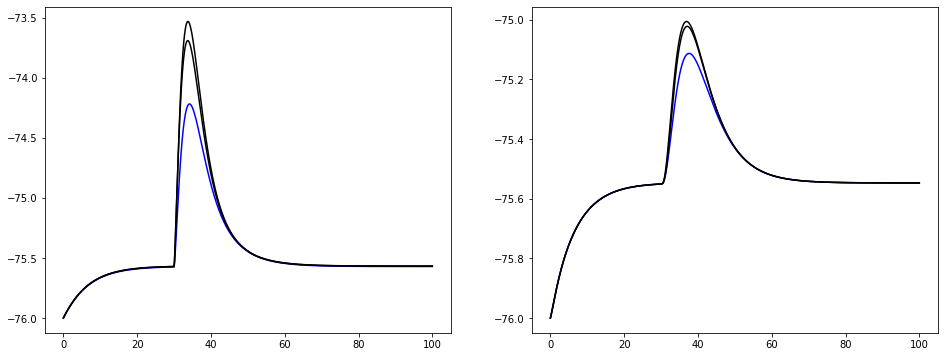

In [38]:
fig = plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(tv,vsec[0].T,c='b')
for n in range(len(vsec)-1):
    plt.plot(tv,vsec[n+1].T,c='k')
plt.subplot(1,2,2)
plt.plot(tv,vsoma[0].T,c='b')
for n in range(len(vsoma)-1):
    plt.plot(tv,vsoma[n+1].T,c='k')

In [72]:
testKa = 0.07
cellID = 7
cutExp = 0

for sec in h.allsec(): h.delete_section(sec=sec)
cell1 = L23(cellID=cellID,cutExperiment=cutExp,dendNa=[naDensity,None,None,False],dendK=[testKa,np.inf,True,False],dxSeg=1,fixDiam=None);

syn = None
syn = None
onset=50
tau=1
gmax=0.0005
tstop = 120
epspDendrite,epspSoma,epspTV,syn = mfx.injectAlphaSites(cell1.sectionList,cell1.segmentList,syn=syn,onset=onset,tau=tau,gmax=gmax,tstop=tstop)
vEpspDend = np.array(epspDendrite)
vEpspSoma = np.array(epspSoma)
tvEpsp = np.array(epspTV)
cEpspAmpDend = np.amax(vEpspDend,axis=1) - vEpspDend[:,np.where(tvEpsp>=onset-1)[0][0]]
cEpspAmpSoma = np.amax(vEpspSoma,axis=1) - vEpspSoma[:,np.where(tvEpsp>=onset-1)[0][0]]

	1 


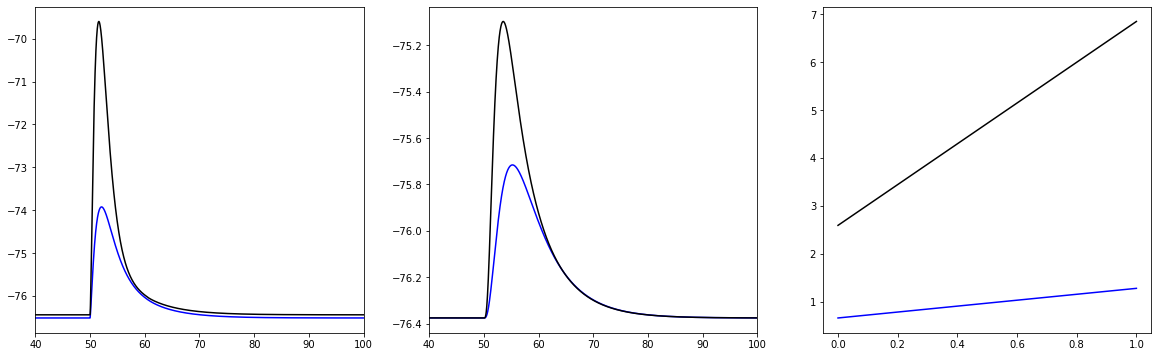

In [73]:
fig = plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
plt.plot(tvEpsp,vEpspDend[0].T,c='b')
for n in range(len(vEpspDend)-1):
    plt.plot(tvEpsp,vEpspDend[n+1].T,c='k')
plt.xlim(40,100)
plt.subplot(1,3,2)
plt.plot(tvEpsp,vEpspSoma[0].T,c='b')
for n in range(len(vEpspSoma)-1):
    plt.plot(tvEpsp,vEpspSoma[n+1].T,c='k')
plt.xlim(40,100)
plt.subplot(1,3,3)
plt.plot(range(len(vEpspDend)),cEpspAmpDend,c='k')
plt.plot(range(len(vEpspDend)),cEpspAmpSoma,c='b')